In [4]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math

def imshow(img, ax=None, title="", bgr=True):
    # since plt and cv2 have different RGB sorting
    if bgr:
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    if ax == None:
        plt.imshow(img.astype(np.uint8))
        plt.axis("off")
        plt.title(title)
    else:
        ax.imshow(img.astype(np.uint8))
        ax.set_axis_off()
        ax.set_title(title)
        
plt.rcParams["figure.figsize"] = (12,6)

## Homography
Given the same object and two images taken from different worlds. WTF the transformation from one to another.

### 3D relationship
Let the object be a plane (say a book). Then we can characterize the plane by one point $d$ and two independent vectors $a,b$ on the plane, i.e. we create a coordinate system with an origin and two basis. Therefore, we can describe any point $X$ on the plane by 
$X = d + \alpha a + \beta b$.  
Let $X_1 = d_1 + \alpha a_1 + \beta b_1, X_2 = d_2 + \alpha a_2 + \beta b_2$ where $X_1, X_2$ represents the two planes in 3D of the two world, and represents the same location relative to the same object plane. 

Using homogeneous coordinates
$$X_1 = 
\underset{A_1}{\begin{bmatrix}
a_{11}&b_{11}&d_{11}\\
a_{12}&b_{12}&d_{12}\\
a_{13}&b_{13}&d_{13}
\end{bmatrix}}
\begin{bmatrix}
\alpha\\\beta\\1 
\end{bmatrix}, X_2 = 
\underset{A_2}{\begin{bmatrix}
a_{21}&b_{21}&d_{21}\\
a_{22}&b_{22}&d_{22}\\
a_{23}&b_{23}&d_{23}
\end{bmatrix}}
\begin{bmatrix}
\alpha\\\beta\\1 
\end{bmatrix}$$
And the transformation $T$ between them gives $X_2 = T X_1$, i.e. $A_2\begin{bmatrix}
\alpha\\\beta\\1 
\end{bmatrix} = TA_1\begin{bmatrix}
\alpha\\\beta\\1 
\end{bmatrix}, \forall \alpha, \beta$. Therefore, $T = A_2A_1^{-1}$

### 2D relationship
Consider the projective (image) plane. Let $K_1,K_2$ denotes the different intrinsic parameters. Then $w_1\begin{bmatrix}x_1\\y_1\\1 \end{bmatrix} = K_1X_1, w_2\begin{bmatrix}x_2\\y_2\\1 \end{bmatrix} = K_2X_2$, known that $X_2 = TX_1$, so that 
$$w_2\begin{bmatrix}x_2\\y_2\\1 \end{bmatrix} = K_2TX_1 = K_2T(K^{-1}_x K_1)X_1= K_2TK_1^{-1}w_1\begin{bmatrix}x_1\\y_1\\1 \end{bmatrix}$$

Note that $K_2TK_1^{-1}$ is a $3\times 3$ matrix. Therefore, without knowing all the 3D location and even the camera parameters, we can still do the transformation by finding $K_2TK_1^{-1}$ as only one matrix

#### Rotating the camera
Consider the panorama mode of the camera. Assuming of the rotation of the camera happens. 

Let $R$ be the rotation of the camera, then $R^T$ is the rotation of the 3D points. Let $X_1,X_2$ be the same point of the object in the two camera coordinates. Then, let $T:= R^T$, i.e. the transformation is a rotation, then 
$$w_2\begin{bmatrix}x_2\\y_2\\1 \end{bmatrix} =w_1 K_2TK_1^{-1}\begin{bmatrix}x_1\\y_1\\1 \end{bmatrix}$$

#### Moving the camera
Let the movement be $t$, then $X_2 = X_1 -t$, so that in the homogeneous coordinate of the 2D image
$$w_2\begin{bmatrix}x_2\\y_2\\1\end{bmatrix} = KX_2 = K(X_1-t) = w_1\begin{bmatrix}x_1\\y_1\\1\end{bmatrix} - Kt$$
However, changing $w_1$ will give different points in the second image. 

On the opposite, if we have $(x_1,y_1), (x_2,y_2), K, t$, we can calculate $w_1, w_2$, hence compute the point in 3D. 

This fact is called __stereo__. 

## Stereo
A 2D image cannot represent the depth in 3D world, i.e. $Z$-axis is dropped. However, using stereo cameras we can reconstruct depth. 

### Parallel stereo Cameras
Let $O_t,O_r$ be two camera centers, $O_r = O_t + [T, 0, 0]^T$, i.e. We apply a movement $t$ to the left camera along the $x$-axis to get our right camera. 

Consider $p_l = (x_l, y_l), p_r = (x_r,y_r)$ be the projected points of $Q$ on left, right image plane, respectively. 

Since we only move the camera along the x-axis, $(p_l\sim p_r) \parallel (O_l\sim O_r)$, hence $y:= y_l = y_r$. 

Also, noticing that we are only interested in $Z$, i.e. the depth. Consider the connection between $p_l, p_r, Z$, ignoring $y$ since it is unchanged. Therefore, we can project the image from the y-axis, and see the relationship in 2D $(x,z)$ coordinate. 

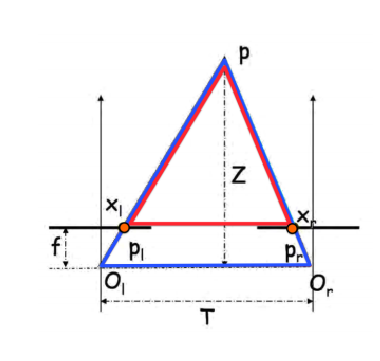

In [5]:
imshow(cv2.imread("../assets/lec13.png"))

Noticing that $\Delta PX_lX_r \sim \Delta PP_lO_r$. so that $$\frac{T}{x_r-x_l} = \frac{Z}{f}\Rightarrow Z = \frac{fT}{x_r - x_l}$$

Then, to get $x_r$, we need to match the point in two images. Since we know $y$ of the point is constant, we can do a sliding window scan along the same $y$, then patch around $x_r$ to get the highest similarity. 

### General Stereo Cameras

#### Basic Setting

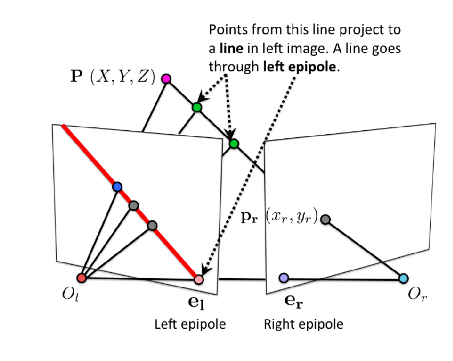

In [6]:
imshow(cv2.imread("../assets/lec14.png"))

__Epipole__ $e_l, e_r$ where line $O_l, O_r$ intersects the image planes  
__Projective line__ $O_lp_l, O_rp_r$ will project to the right, left image plane. Note that the line will not (necessarily) be horizontal.  
__Epipolar plane__ the triangular 2D plane in 3D space that it formed by $O_lO_rP$, where $P$ is an arbitrary point in the camera's view point.  
__Epipolar line__ the intersection between the epipolar plane and the image plane. However, all epipolar line will intersection at $e_l, e_r$

Given $p_l$ in the left image plane, we are able to compute the epipolar plane passing through $p_l$ and hence the correspondent epilolar line in right image, hence search $p_r$ on a line. 

#### Cross Product 
For two $3\times 1$ vectors $u,v$, the cross product is defined as 
$$u\times v = [u]_x v, [u]_x = \begin{bmatrix}0&-u_3&u_2\\u_3&0&-u_1\\-u_2&u_1&0\end{bmatrix}, u\times v=\begin{bmatrix}u2v3-u3v2\\u_3v_1-u_1v_3\\u_1v_2-u_2v_1\end{bmatrix}$$

Note that $u\times u =0$ and $u\parallel v \Leftrightarrow u\times v = 0$

Geometrically, the cross product defines the line perpendicular to both $u,v$, i.e. $u\cdot(u\times v) = v\cdot(u\times v) = 0$. 

#### Essential Matrix $E$
maps 3D points from the frame of one camera to the frame of another camera. 

Consider $X_l, X_r$ be the same 3D point in left, right camera frames. Because we are changing the perspective on the same point, we are get the transformation by a translation and a rotation
\begin{align*}
X_l &= RX_r + T\\
T\times X_l &= T\times RX_r + T\times T\\
X_l\cdot (T\times X_l) &= X_l\cdot (T\times X_r) + 0\\
0 &= X_l\cdot T\times RX_r&(T\times X_l)\perp X_l\\
X_l\cdot([T]_xRX_r) &= 0\\
X_l^TEX_r &= 0&E:=[T]_xR
\end{align*}

#### Fundamental Matrix $F$
Let $I_r$ ne the epipolar line corresponding to $p_l$, the fundamental matrix $I_r= Fp_l$. Note that for any $p_l$, $F$ is unchanged. 

Note that for any point $P$, its projection on the 2D image frame is $p = K[R\mid t]P$ (projection matrix)

Since both 3D points on the image frame are the identical 3D point in the world. Let $X_l = [R_l\mid t_l]P, X_r = [R_r\mid t_r]P$, assuming using the same camera, i.e. the same $K$. Therefore, $p_l = KX_l, p_r = KX_r\Rightarrow X_l = K^{-1}p_l, X_r = K^{-1}p_r$

Therefore, $(K^{-1}p_l)^T E K^{-1}p_r = 0$, then $p_l^T(K^{-1})^TEK^{-1}p_r = 0\Rightarrow p_l^TFp_r = 0$, where $F:= (K^{-1})^TEK^{-1}$

Noting that $p_l^TFp_r = 0\Leftrightarrow p_l^T100Fp_r = 0$, i.e. $F$ is scale independent, also note that $E$ is rank 2, hence $F$ is rank 2. $\Rightarrow \det F = 0$. Therefore, degree of freedom is $9-1-1=7$

#### Computing $F$ (8 Point matching algorithm)
Consider $8$ matching points, $p_{l1}, p_{r1},...,p_{l8}, p_{r8}$. Then, we have 8 equations $p_{li}Fp_{lr} = 0$. We can flatten $F\rightarrow \vec f$ and write the equations as vector products $a_i\vec f = 0$. Then, we can form system of equations
$$A\vec f = \vec 0 \Rightarrow \begin{bmatrix}
[\vec a_1]\\
...\\
[\vec a_8]
\end{bmatrix}\vec f = \vec 0$$
Note that $\vec f$ is the null space of $A$. Using SVD, $A = UDV^T$, and set $\vec f$ to the column of $V$ corresponds to the smallest singular value in $D$, and reshape $\vec f$ to $F$. 

Then, we can impose $\det F= 0$ constraint by SVD on $F = UDV^T, D= diag(d_1,d_2,d_3)$ where $d_1>d_2>d_3$, then we can set $d_3=0$, i.e. $\hat D = diag(d_1,d_2,0)$ and let output $\hat F = U\hat DV^T$

#### Computing epipolar lines
Note that $F$ is scale invariant, hence $p_l^TFp_r = 0\Rightarrow l_l = Fp_r$ is the epipolar line on the left image.  

Similarly, $p_l^TFp_r = 0\Rightarrow (p_l^TFp_r)^T = 0\Rightarrow p_r^TF^Tp_l = 0\Rightarrow l_r = F^Tp_l$ is the eipolar line on the right image.

#### Computing epipoles
Wlog, using the left image.   
Note that all epipolar lines $l_l$ intersect at $e_l$, hence $e_l^Tl_l = e_l^TF^Tp_l = 0$, take $p_l=1$, then we solve $e_l^TF^T = 0$, and $e_l=$ vector that is null space of $F$ (rank 2). 

#### Rectification Matrix
If $F$ is knowing, we can compute the relative poses of the two cameras. 

Setting $P_l = [I_{3\times 3}\mid 0]$ be the reference camera, $P_r = [[e_r]_xF\mid e_r]$, then $P_r$ is the rectified projection matrix. 